In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import pymc3 as pm 
import os 

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font) 


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
from scipy import stats
from pymc3.distributions import draw_values
from pymc3.distributions import generate_samples
from pymc3.theanof import floatX
from pymc3.distributions.dist_math import bound
from pymc3.distributions import (Continuous, draw_values, generate_samples)

def assert_negative_support(var, label, distname, value=-1e-6):
    # Checks for evidence of positive support for a variable
    if var is None:
        return
    try:
        # Transformed distribution
        support = np.isfinite(var.transformed.distribution.dist
                              .logp(value).tag.test_value)
    except AttributeError:
        try:
            # Untransformed distribution
            support = np.isfinite(var.distribution.logp(value).tag.test_value)
        except AttributeError:
            # Otherwise no direct evidence of non-positive support
            support = False

    if np.any(support):
        msg = "The variable specified for {0} has negative support for {1}, ".format(
            label, distname)
        msg += "likely making it unsuitable for this parameter."
        warnings.warn(msg)

def get_tau_sigma(tau=None, sigma=None):
    if tau is None:
        if sigma is None:
            sigma = 1.
            tau = 1.
        else:
            tau = sigma**-2.
    else:
        if sigma is not None:
            raise ValueError("Can't pass both tau and sigma")
        else:
            sigma = tau**-.5
    tau = 1. * tau
    sigma = 1. * sigma
    return floatX(tau), floatX(sigma)



class weighted_Normal(pm.distributions.Continuous):

    def __init__(self, mu=0, sigma=None, tau=None, sd=None, weight =None,**kwargs):
        if sd is not None:
            sigma = sd
        tau, sigma = get_tau_sigma(tau=tau, sigma=sigma)
        self.sigma = self.sd = tt.as_tensor_variable(sigma)
        self.tau = tt.as_tensor_variable(tau)
        self.weight = tt.as_tensor_variable(weight)

        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
        self.variance = 1. / self.tau

        assert_negative_support(sigma, 'sigma', 'Normal')
        assert_negative_support(tau, 'tau', 'Normal')

        super().__init__(**kwargs)

    def random(self, point=None, size=None):
        
        mu, tau, _ = draw_values([self.mu, self.tau, self.sigma],
                                 point=point, size=size)
        return generate_samples(stats.norm.rvs, loc=mu, scale=tau**-0.5,
                                dist_shape=self.shape,
                                size=size)

    def logp(self, value):
        """
        Sum of Squares
        
        """
        sigma = self.sigma
        tau = self.tau
        mu = self.mu
        weight = self.weight
        
        logp =  - weight.T * tt.sqr(value - mu)/(2.0 * sigma * sigma)
        return logp.sum()


In [3]:
import pandas as pd
cwd = os.chdir('/Users/jackcarter/Documents/Data_Mixtures')
df = pd.read_csv("Penns_labradorite_y.csv")

In [4]:
df.head()

,Age,Age_Er,Ar40_,Ar40_Er,Ar39_,Ar39_Er,Pwr_Achieved,Dur_Heating_At_Req_Pwr,Da2,Da2_err
0,346.0114,82.54041,0.020721,0.000088,0.000595,0.000019,427,2996,5.610000e-10,3.760000e-11
1,445.1564,27.90027,0.058440,0.000120,0.002004,0.000025,471,1996,1.520000e-08,2.330000e-10
2,170.8447,52.37285,0.031670,0.000067,0.001238,0.000014,472,1997,1.900000e-08,2.740000e-10
3,279.3306,26.32661,0.073516,0.000160,0.003368,0.000032,515,1996,8.850000e-08,6.840000e-10
4,438.6970,30.89230,0.041460,0.000078,0.001972,0.000022,515,1997,7.690000e-08,7.240000e-10


In [5]:
temp = df['Pwr_Achieved'].values
time = df['Dur_Heating_At_Req_Pwr'].values
ar39 = df['Ar39_'].values
ar39_err = df['Ar39_Er'].values

In [6]:
N = temp.shape[0] - 1
N

27

In [7]:
# Part 1 ThermoCouple T Calibration 
## Step 1: Pyrometer Calibration
import os 
cwd = os.getcwd()
os.chdir("/Users/jackcarter/Desktop/Downloads")
df1 = pd.read_csv("PyroApril2018.csv")
c1 = df1.iloc[:,0:1]
c2 = df1.iloc[:,1:2]
x1 = c1.values
x2 = c2.values
x1 = x1[x1 >=0]
x2 = x2[x2 >=0]
ThermoT = x2
PyroT = x1
zpt = np.polyfit(x1,x2,3)

In [8]:
temp = np.polyval(zpt, temp)

In [9]:
da2 = df['Da2'].values
da2_err = df['Da2_err'].values

In [10]:
tplot = 1e4/(temp + 273.15)

In [11]:
"""
Plot Style
"""

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font) 
sns.set_style('ticks')

In [12]:
def cumrel(x): 
    y = np.cumsum(x)
    z = y/y.max()
    return z

In [13]:
ar39 = cumrel(ar39)
age = df['Age'].values
age_err = df['Age_Er'].values
data3 = ar39

In [14]:
# Plotting parameters

age_plot = np.insert(age,
                     0, age[0])
age_plot_err =  np.insert(age_err, 
                         0, age_err[0])
ar39_plot = np.insert(ar39,
                      0, 0)

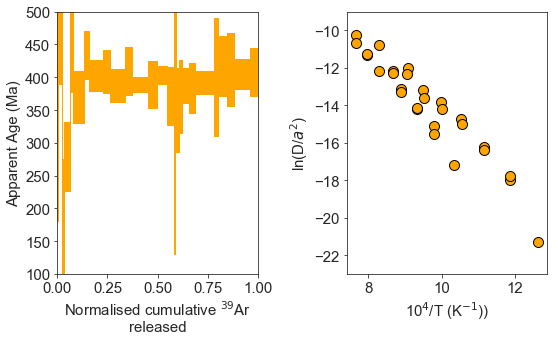

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (8,5))

ax[0].fill_between(ar39_plot, 
                age_plot + 2*age_plot_err, 
                age_plot - 2*age_plot_err, 
                color = 'orange', 
                step = 'pre')

ax[0].set_ylim(100, 500)
ax[0].set_xlim(0,1)

ax[0].set_ylabel('Apparent Age (Ma)')
ax[0].set_xlabel('Normalised cumulative $^{39}$Ar\nreleased');
ax[1].errorbar(tplot, np.log(da2),
             yerr = (da2_err/da2),
       fmt =  'o', 
        markersize = 10, 
        color = 'orange', 
        markeredgecolor = 'k')

ax[1].set_xlabel('10$^{4}$/T (K$^{-1}$))')
ax[1].set_ylabel('ln(D/$a^{2}$)')
ax[1].set_ylim(-23, -9)

plt.tight_layout()
plt.savefig('pens_lab_age_arr.pdf')

In [21]:
"""
Fitting the Arrhenius Array
"""
from theano import shared
N = len(da2)
arr_data = shared(np.log(da2[:N]))
arr_err = shared((da2_err[:N]/da2[:N]))
N = N
tempk = temp[:N] + 273.15

In [23]:
"""
Stick Breaking 
"""
import pymc3.distributions.transforms as tr
from theano import tensor as tt
def stick_break(beta): 
    pr = tt.concatenate([[1], 
                         tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * pr

In [24]:
m = 10
Q = pm.Model()
with Q: 
    # Global Component Distribution
    alpha = pm.Gamma('alpha', 
                         1., 1.)

    beta = pm.Beta('beta', 1., alpha, 
                      shape = m)

    K_w = stick_break(beta)
    
    K = pm.Deterministic('K', 
                        K_w/K_w.sum(axis = 0,
                                    keepdims = True))
    
    D = pm.Categorical('D', 
                       p = K, 
                       shape = N)

In [25]:
with Q: 
    # Diffusion Kinetics 
    ea = pm.Uniform('Ea',
                      lower = 120, 
                      upper = 500)
    
    d0 = pm.Uniform('d0',  
                      lower = 0.0, 
                      upper = 10000)

In [26]:
with Q: 
    # MDD/GSD
    a = pm.Uniform('a', lower = 0.00001, 
                  upper = 0.025, 
                  shape = m)

In [27]:
with Q: 
    
    a_domain = pm.Deterministic("a_domain",
                                a[D])
    phi_domain = pm.Deterministic('phi_domain',
                                  K[D])

In [28]:
with Q:
    R = 8.314e-3
    
    y2 = (((phi_domain/a_domain)**2) \
                 * d0 * np.exp(-ea/(R*tempk)))
    
    mu1 = tt.log(y2)

In [29]:
with Q: 
    arr_err_m = pm.HalfNormal('arr_err_m',
                             sd = 0.05, 
                             shape= N)

In [30]:
with Q: 
    obs2 = weighted_Normal('obs2', mu1[:N],
                     arr_err_m, 
                     observed = arr_data[:N], 
                          weight = 1) 

In [31]:
Q.check_test_point()

alpha_log__            -1.00
beta_logodds__        -13.86
D                     -19.38
Ea_interval__          -1.39
d0_interval__          -1.39
a_interval__          -13.86
arr_err_m_log__       -21.56
obs2              -358765.38
Name: Log-probability of test_point, dtype: float64

In [32]:
SAMPLES = 100000
BURN = 100000
SEED = np.random.seed(123)

with Q:
    step1 = pm.CategoricalGibbsMetropolis([D]) 
    
    step2 = pm.Metropolis([alpha, 
                           beta,
                           d0, 
                           ea,
                           a], 
                         scaling = 10)
    
    
    trace = pm.sample(SAMPLES, tune = BURN, 
                     step = [step1,
                             step2],
                     random_seed = SEED)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [D]
>CompoundStep
>>Metropolis: [a]
>>Metropolis: [Ea]
>>Metropolis: [d0]
>>Metropolis: [beta]
>>Metropolis: [alpha]
>NUTS: [arr_err_m]
Sampling 2 chains: 100%|██████████| 400000/400000 [1:17:02<00:00, 26.08draws/s] 
There were 2375 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1035 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


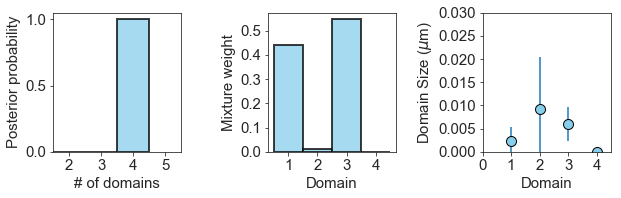

In [35]:
"""
Number of Domains
"""
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

fig, ax = plt.subplots(1, 3, figsize = (9, 3))
n_comp = np.apply_along_axis(lambda x: np.unique(x).size, 
                            1, trace['D'][-SAMPLES:])

n_comp =  n_comp+ 1
ncmp = n_comp.mean(axis = 0).astype(int)
bins = np.arange(n_comp.min() -2 , n_comp.max() + 2)

ax[0].hist(n_comp ,
        bins=bins,
        density=True,
        lw= 2,
        alpha=0.75, 
       edgecolor = 'k', 
        facecolor = 'skyblue');

ax[0].set_xticks(bins + 0.5);
ax[0].set_xticklabels(bins);
ax[0].set_xlim(bins.min(),bins.max() + 1);

plot_w = np.arange(ncmp) + 1

ax[1].bar(plot_w - 0, trace['K'][-SAMPLES:].mean(axis=0)[:ncmp],
          width=1., lw=2, 
      edgecolor = 'k', alpha = 0.75, 
         facecolor = 'skyblue');



ax[2].errorbar(np.linspace(1, ncmp,ncmp),
             trace['a'][-SAMPLES::10].mean(axis = 0)[:ncmp], 
             yerr = 2*trace['a'][-SAMPLES:].std(axis = 0)[:ncmp], 
             fmt ='o', 
             markersize = 10, 
             markeredgecolor = 'k', 
             markerfacecolor = 'skyblue')

ax[2].set_xlabel('Domain');
ax[1].set_xlabel('Domain');
ax[2].set_ylabel('Domain Size ($\mu$m)');
ax[1].set_ylabel('Mixture weight');
ax[0].set_xlabel('# of domains');
ax[0].set_ylabel('Posterior probability')
ax[2].set_ylim(0, 0.03)
ax[2].locator_params(axis='x', nbins=ncmp + 1)
ax[1].locator_params(axis='x', nbins=ncmp + 1)
ax[2].locator_params(axis='y', nbins=ncmp + 3)
ax[1].locator_params(axis='y', nbins=ncmp + 3)

ax[2].set_xlim(0, ncmp + 0.5)

plt.tight_layout()
plt.savefig('/Users/jackcarter/Desktop/chp3_figs/pen_lab_ncomp.pdf')

In [36]:
with Q: 
    ppc = pm.sample_ppc(trace,
                        5000)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 5000/5000 [05:41<00:00, 14.63it/s]


In [37]:
def arr_plot(ea, d0, a, temp): 
    R = 8.314e-3
    da2 = (d0/a.max()**2) * np.exp(-ea/(R*temp))
    
    return np.log(da2)

In [38]:
tplot2 = 10000/tempk[1:N]
tplot = 10000/tempk
# Mean Predictive Models
Z1 = ppc['obs2'].mean(axis = 0)
low1, high1 = np.percentile(ppc['obs2'], [50 - 34, 50 + 34], axis = 0)

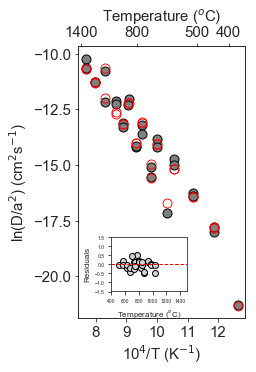

In [39]:
fig, ax = plt.subplots(1,1,figsize = (3,5))
plt.plot(tplot[:N], np.log(da2[:N]), 
          'o', markerfacecolor = 'grey', 
          markeredgecolor = 'k', 
          markersize = 9, label = 'Data')


plt.plot(tplot[:N],Z1[:N], 'or',
             markerfacecolor = 'None',
            alpha = 1, 
             markeredgecolor = 'r', markeredgewidth = 0.9, 
            markersize = 9, 
            label = 'Model')



plt.xlabel('10$^{4}$/T (K$^{-1}$)')
plt.ylabel('ln(D/a$^{2}$) (cm$^{2}$s$^{-1}$)')
plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=6)

ax3 =plt.axes([0.28,0.2,0.35,0.15])

ax3.plot(tempk[:N] - 273.15, Z1 - np.log(da2[:N]), 'ok', 
        markeredgecolor = 'k', 
        markerfacecolor = 'lightgrey')
qqq = Z1 - np.log(da2[:N])
ax3.axhline(0, lw = 1, ls = '--', 
           color = 'r')
ax3.set_ylabel('Residuals', fontsize = 8)
ax3.set_xlabel('Temperature ($^{o}$C)', fontsize = 8)
ax3.set_ylim(qqq.min() - 1, qqq.max() + 1)
ax3.tick_params(labelsize = 5)
ax3.locator_params(axis='x', nbins=6)
ax3.set_xlim(400, 1500)

plt.locator_params(axis='y', nbins=8)
plt.locator_params(axis='x', nbins=8)


ax5 = ax.twiny()

Tdc = np.array([400,  500, 800,  1400])
Tp = 10e3/(Tdc + 273.15)
labels = list(['400', '500', '800',   
              '1400'])
ax5.plot(tplot[:N], np.log(da2[:N]), alpha = 0)
plt.xlim(Tp.min() - 0.2, Tp.max()+ 1)
ax5.set_xlim(Tp.min() -0.2, Tp.max()+ 1)
ax5.set_xticks(Tp)
ax5.set_xticklabels(labels)
ax5.set_xlabel('Temperature ($^{o}$C)')
plt.savefig('pens_lab_mod.pdf')

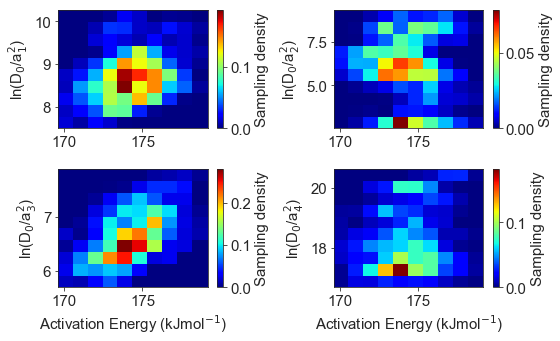

In [41]:
fig, ax = plt.subplots(2, 2, figsize = (8,5))

z1 = ax[0,0].hist2d(x = trace['Ea'][-SAMPLES::10],
                    y = np.log(trace['d0'][-SAMPLES::10]/trace['a'][-SAMPLES::10][:,0]**2), normed = True, 
          cmap = 'jet'); 

z2 = ax[0,1].hist2d(x = trace['Ea'][-SAMPLES::10],
         y = np.log(trace['d0'][-SAMPLES::10]/trace['a'][-SAMPLES::10][:,1]**2)
                  , normed = True, 
          cmap = 'jet'); 


z3 = ax[1,0].hist2d(x = trace['Ea'][-SAMPLES::10],
        y = np.log(trace['d0'][-SAMPLES::10]/trace['a'][-SAMPLES::10][:,2]**2)
                  , normed = True, 
          cmap = 'jet'); 

z4 = ax[1,1].hist2d(x = trace['Ea'][-SAMPLES::10],
        y = np.log(trace['d0'][-SAMPLES::10]/trace['a'][-SAMPLES::10][:,3]**2)
                  , normed = True, 
          cmap = 'jet'); 

cbar1 = plt.colorbar(z1[3], ax=ax[0,0])
cbar2 = plt.colorbar(z2[3], ax=ax[0,1])
cbar3 = plt.colorbar(z3[3], ax=ax[1,0])
cbar4 = plt.colorbar(z4[3], ax=ax[1,1])
cbar1.set_label('Sampling density')
cbar2.set_label('Sampling density')
cbar3.set_label('Sampling density')
cbar4.set_label('Sampling density')




ax[0,0].set_ylabel('ln(D$_{0}$/a$^{2}_{1}$)')
ax[0,1].set_ylabel('ln(D$_{0}$/a$^{2}_{2}$)')
ax[1,0].set_ylabel('ln(D$_{0}$/a$^{2}_{3}$)')
ax[1,1].set_ylabel('ln(D$_{0}$/a$^{2}_{4}$)')


ax[1,1].set_xlabel('Activation Energy (kJmol$^{-1}$)')
ax[1,0].set_xlabel('Activation Energy (kJmol$^{-1}$)')

plt.tight_layout()
plt.savefig('/Users/jackcarter/Desktop/chp3_figs/pen_lab_diff_kin.pdf')

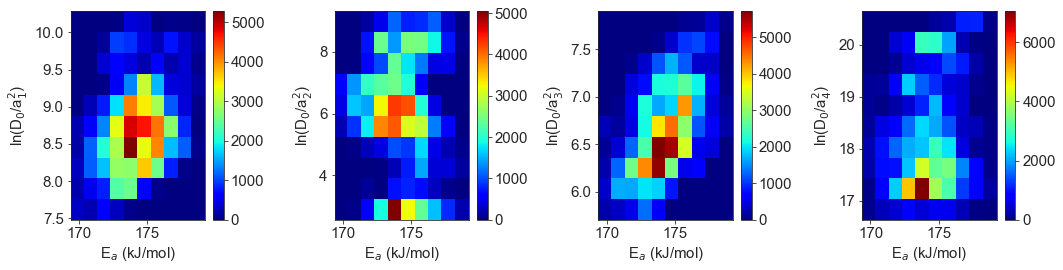

In [56]:
plt.figure(figsize = (15, 4))
for i in range(ncmp): 
    plt.subplot(1, ncmp, i+1)
    plt.hist2d(trace['Ea'][-SAMPLES:],
                np.log(trace['d0'][-SAMPLES:]/trace['a'][-SAMPLES:][:,i]**2), 
               cmap = 'jet')


    plt.ylabel(f'ln(D$_{0}$/a$^{2}_{i+1}$)')
    plt.xlabel('E$_{a}$ (kJ/mol)')
    plt.colorbar()


    plt.tight_layout()
plt.savefig('/Users/jackcarter/Desktop/chp3_figs/pen_lab_diff_kin.pdf')

In [49]:
y1 = trace['d0'][-SAMPLES::10]
y2 = trace['Ea'][-SAMPLES::10]

In [50]:
y1.mean(), y1.std()

(0.034859134363521706, 0.030833040579438697)

In [51]:
y2.mean(), y2.std()

(174.27562710499, 1.7139942113390245)

In [52]:
def arr_plot(ea, d0, a, phi, temp): 
    R = 8.314e-3
    da2 = ((phi/a)**2) * d0 * np.exp(-ea/(R*temp))
    
    return np.log(da2)

temp = np.linspace(400, 1500, 10)

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


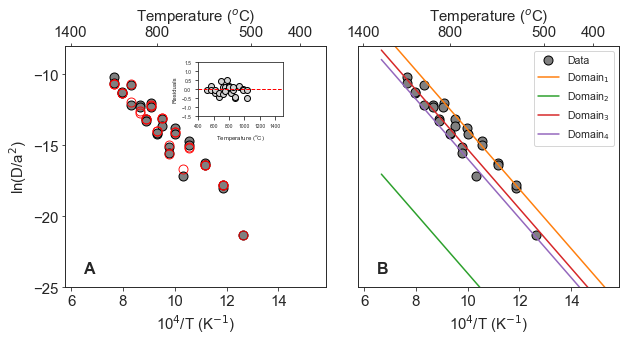

In [57]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
sns.set_style('ticks')

fig, ax = plt.subplots(1,2, figsize= (9,5))
ax[0].plot(tplot[:N], np.log(da2[:N]), 
          'o', markerfacecolor = 'grey', 
          markeredgecolor = 'k', 
          markersize = 9, label = 'Data')


ax[0].plot(tplot[:N],Z1[:N], 'or',
             markerfacecolor = 'None',
            alpha = 1, 
             markeredgecolor = 'r', markeredgewidth = 0.9, 
            markersize = 9, 
            label = 'Model')



ax[0].set_xlabel('10$^{4}$/T (K$^{-1}$)')
ax[0].set_ylabel('ln(D/a$^{2}$)')
ax[0].locator_params(axis='y', nbins=6)
ax[0].locator_params(axis='x', nbins=6)



ax[1].plot(tplot[:N], np.log(da2[:N]), 
          'o', markerfacecolor = 'grey', 
          markeredgecolor = 'k', 
          markersize = 9, label = 'Data')

for i in range(ncmp): 
    ax[1].plot(10000/temp, 
            arr_plot(trace['Ea'][-SAMPLES:].mean(axis = 0)
                     , trace['d0'][-SAMPLES:].mean(axis = 0), 
                     trace['a'][-SAMPLES:].mean(axis = 0)[i],
                     trace['K'][-SAMPLES:].mean(axis = 0)[i],
                    temp), 
              label = f'Domain$_{i+1}$')
    
ax[1].set_xlabel('10$^{4}$/T (K$^{-1}$)')
ax[1].locator_params(axis='y', nbins=6)
ax[1].locator_params(axis='x', nbins=6)
ax[1].legend(fontsize = 10.5)


ax3 =plt.axes([0.32,0.65,0.13,0.15])

ax3.plot(tempk[:N] - 273.15, Z1[:N] - np.log(da2[:N]), 'ok', 
        markeredgecolor = 'k', 
        markerfacecolor = 'lightgrey')
qqq = Z1[:N] - np.log(da2[:N])
ax3.axhline(0, lw = 1, ls = '--', 
           color = 'r')
ax3.set_ylabel('Residuals', fontsize = 6)
ax3.set_xlabel('Temperature ($^{o}$C)', fontsize = 6)
ax3.set_ylim(qqq.min() - 1, qqq.max() + 1)
ax3.tick_params(labelsize = 5)
ax3.locator_params(axis='x', nbins=6)
ax3.set_xlim(400, 1500)

plt.locator_params(axis='y', nbins=8)
plt.locator_params(axis='x', nbins=8)


ax5 = ax[0].twiny()
Tdc = np.array([400,  500, 800,  1400])
Tp = 10e3/(Tdc + 273.15)
labels = list(['400', '500', '800',   
              '1400'])
ax5.plot(tplot[:N], np.log(da2[:N]), alpha = 0)
ax[0].set_xlim(Tp.min() - 0.2, Tp.max()+ 1)
ax5.set_xlim(Tp.min() -0.2, Tp.max()+ 1)
ax5.set_xticks(Tp)
ax5.set_xticklabels(labels)
ax5.set_xlabel('Temperature ($^{o}$C)')


ax6 = ax[1].twiny()
Tdc = np.array([400,  500, 800,  1400])
Tp = 10e3/(Tdc + 273.15)
labels = list(['400', '500', '800',   
              '1400'])
ax6.plot(tplot[:N], np.log(da2[:N]), alpha = 0)
ax[1].set_xlim(Tp.min() - 0.2, Tp.max()+ 1)
ax6.set_xlim(Tp.min() -0.2, Tp.max()+ 1)
ax6.set_xticks(Tp)
ax6.set_xticklabels(labels)
ax6.set_xlabel('Temperature ($^{o}$C)')
ax[1].set_ylim(-25, -8)
ax[0].set_ylim(-25, -8)
ax[1].set_yticks([])

ax[0].text(6.5, -24, 'A', 
          fontsize = 16, 
          fontweight = 'bold')

ax[1].text(6.5, -24, 'B', 
          fontsize = 16, 
          fontweight = 'bold')

plt.tight_layout()
plt.savefig('/Users/jackcarter/Desktop/chp3_figs/pen_lab_mod.pdf')

In [139]:
df_out_model = pd.DataFrame({
                      'model':Z1[:N], 
                      'data': da2[:N], 
                       'data_err': da2_err[:N], 
                      'model_err': low1[:N] - high1[:N], 
                      'tempk': tempk[:N]})

df_out_trace = pd.DataFrame({'ea': trace['Ea'][-SAMPLES::10], 
                      'd0': trace['d0'][-SAMPLES::10], 
                      'a1': trace['a'][:,0][::10].mean(axis = 0), 
                      'a2': trace['a'][:,1][::10].mean(axis = 0), 
                      'a3': trace['a'][:,2][::10].mean(axis = 0)})


df_age_out = pd.DataFrame({"age_plot":age_plot, 
                          "age_err_plot":age_plot_err, 
                          "ar39_plot":ar39_plot})


df_out_model.to_csv('pen_lab_model.csv')
df_out_trace.to_csv('pen_lab_trace.csv')
df_age_out.to_csv('pen_lab_age_spec.csv')